In [1]:
#pip install torchinfo

In [2]:
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

In [3]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [4]:
# Define transforms: Used to preprocess the images before feeding them into the model
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.ToTensor(),  # Converts the image to a tensor, normalizing pixel values to the range [0, 1]
    transforms.Resize((224, 224)),
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the image to range [-1, 1], making it easier for the model to learn
])

In [5]:
train_dir = "/kaggle/input/bone-fracture/dataset/train"
test_dir = "/kaggle/input/bone-fracture/dataset/test"
val_dir = "/kaggle/input/bone-fracture/dataset/val"

In [6]:
# Creating training and testing datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)  # Load training data with transformations
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)  # Load test data with transformations
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)  # Load Val data with transformations
### Train
print("Train:\n","*"*20)
print(f"Number of samples: {len(train_dataset)}")  
print(f"Class names: {train_dataset.classes}")  
print(f"Class-to-index mapping: {train_dataset.class_to_idx}") 
print(f"Image size (first sample): {train_dataset[0][0].size()}")  
print(f"Data directory: {train_dataset.root}") 
### Test
print("Test:\n","*"*20)
print(f"Number of samples: {len(test_dataset)}")  
print(f"Class names: {test_dataset.classes}")  
print(f"Class-to-index mapping: {test_dataset.class_to_idx}") 
print(f"Image size (first sample): {test_dataset[0][0].size()}")  
print(f"Data directory: {test_dataset.root}") 
### Validation
print("Test:\n","*"*20)
print(f"Number of samples: {len(val_dataset)}")  
print(f"Class names: {val_dataset.classes}")  
print(f"Class-to-index mapping: {val_dataset.class_to_idx}") 
print(f"Image size (first sample): {val_dataset[0][0].size()}")  
print(f"Data directory: {val_dataset.root}") 

Train:
 ********************
Number of samples: 4097
Class names: ['fractured', 'not fractured']
Class-to-index mapping: {'fractured': 0, 'not fractured': 1}
Image size (first sample): torch.Size([3, 224, 224])
Data directory: /kaggle/input/bone-fracture/dataset/train
Test:
 ********************
Number of samples: 399
Class names: ['fractured', 'not fractured']
Class-to-index mapping: {'fractured': 0, 'not fractured': 1}
Image size (first sample): torch.Size([3, 224, 224])
Data directory: /kaggle/input/bone-fracture/dataset/test
Test:
 ********************
Number of samples: 404
Class names: ['fractured', 'not fractured']
Class-to-index mapping: {'fractured': 0, 'not fractured': 1}
Image size (first sample): torch.Size([3, 224, 224])
Data directory: /kaggle/input/bone-fracture/dataset/val


In [7]:
# Create DataLoaders: DataLoaders are used to iterate over the dataset in batches during training/testing.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle training data for randomness
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No shuffle for test data, it’s typically not needed
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # No shuffle for val data, it’s typically not needed

In [8]:
classes = train_dataset.classes
classes

['fractured', 'not fractured']

In [ ]:
# Function to visualize a batch of images
def show_batch(loader,predict_labels=[]):
    data_iter = iter(loader)  # Convert the loader to an iterator
    images, labels = next(data_iter)  # Get a batch of images and labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))  # Set up a grid of 2 rows and 5 columns to show images
    for i, ax in enumerate(axes.flat):  # Loop through each subplot (flattened 2D array)
        ax.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for RGB display4
        title = f"Label: {classes[labels[i]]}"
        if len(predict_labels):
            title = f"Label: {classes[labels[i]]}\nPredict: {classes[predict_labels[i]]}"
        ax.set_title(title)  # Set the title of the subplot as the label for each image
        ax.axis('off')  # Hide axis to focus on images
    plt.show()

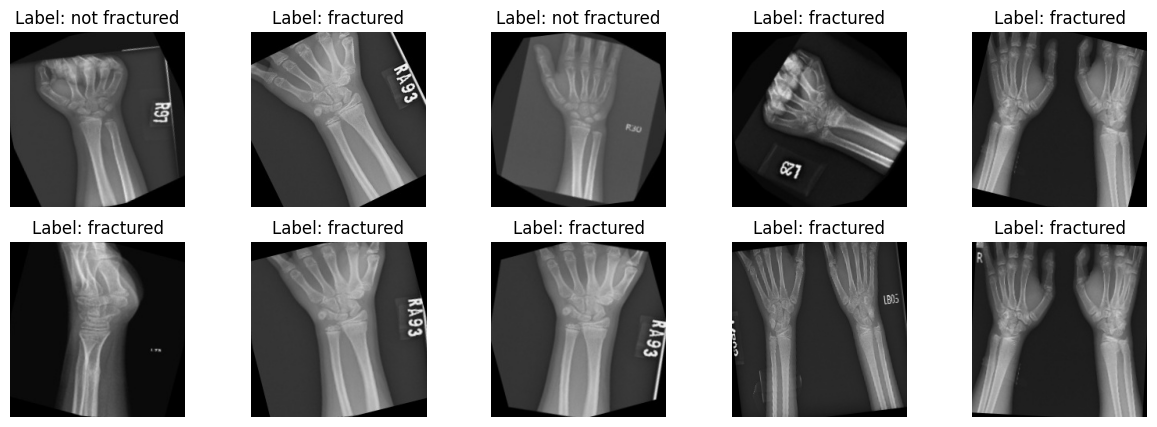

In [10]:
# Show a batch of images: This function will show a random batch of images from the training set.
show_batch(train_loader)  

In [11]:
### Create Custom Function to Calculate Mean & Std for Normilization
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for Images, labels in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(Images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(Images**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.2283, 0.2283, 0.2283])
Standard deviation: tensor([0.2166, 0.2166, 0.2166])


In [12]:
# Define transforms: Used to preprocess the images before feeding them into the model
transform_norm = transforms.Compose([ 
    ConvertToRGB(),
    transforms.ToTensor(),  # Converts the image to a tensor, normalizing pixel values to the range [0, 1]
    transforms.Resize((224, 224)),
    transforms.Normalize(mean,std)  # Normalize the image to range [-1, 1], making it easier for the model to learn
])

In [13]:
# Creating training and testing datasets using ImageFolder
train_dataset_norm = datasets.ImageFolder(root=train_dir, transform=transform_norm)  # Load training data with transformations
test_dataset_norm = datasets.ImageFolder(root=test_dir, transform=transform_norm)  # Load test data with transformations
val_dataset_norm = datasets.ImageFolder(root=val_dir, transform=transform_norm)  # Load Val data with transformations
### Train
print("Train:\n","*"*20)
print(f"Number of samples: {len(train_dataset_norm)}")  
print(f"Class names: {train_dataset_norm.classes}")  
print(f"Class-to-index mapping: {train_dataset_norm.class_to_idx}") 
print(f"Image size (first sample): {train_dataset_norm[0][0].size()}")  
print(f"Data directory: {train_dataset_norm.root}") 
### Test
print("Test:\n","*"*20)
print(f"Number of samples: {len(test_dataset_norm)}")  
print(f"Class names: {test_dataset_norm.classes}")  
print(f"Class-to-index mapping: {test_dataset_norm.class_to_idx}") 
print(f"Image size (first sample): {test_dataset_norm[0][0].size()}")  
print(f"Data directory: {test_dataset_norm.root}") 
### Validation
print("Test:\n","*"*20)
print(f"Number of samples: {len(val_dataset_norm)}")  
print(f"Class names: {val_dataset_norm.classes}")  
print(f"Class-to-index mapping: {val_dataset_norm.class_to_idx}") 
print(f"Image size (first sample): {val_dataset_norm[0][0].size()}")  
print(f"Data directory: {val_dataset_norm.root}") 

Train:
 ********************
Number of samples: 4097
Class names: ['fractured', 'not fractured']
Class-to-index mapping: {'fractured': 0, 'not fractured': 1}
Image size (first sample): torch.Size([3, 224, 224])
Data directory: /kaggle/input/bone-fracture/dataset/train
Test:
 ********************
Number of samples: 399
Class names: ['fractured', 'not fractured']
Class-to-index mapping: {'fractured': 0, 'not fractured': 1}
Image size (first sample): torch.Size([3, 224, 224])
Data directory: /kaggle/input/bone-fracture/dataset/test
Test:
 ********************
Number of samples: 404
Class names: ['fractured', 'not fractured']
Class-to-index mapping: {'fractured': 0, 'not fractured': 1}
Image size (first sample): torch.Size([3, 224, 224])
Data directory: /kaggle/input/bone-fracture/dataset/val


In [14]:
# Create DataLoaders: DataLoaders are used to iterate over the dataset in batches during training/testing.
train_loader_norm = DataLoader(train_dataset_norm, batch_size=64, shuffle=True)  # Shuffle training data for randomness
test_loader_norm = DataLoader(test_dataset_norm, batch_size=64, shuffle=False)  # No shuffle for test data, it’s typically not needed
val_loader_norm = DataLoader(val_dataset_norm, batch_size=64, shuffle=False)  # No shuffle for test data, it’s typically not needed

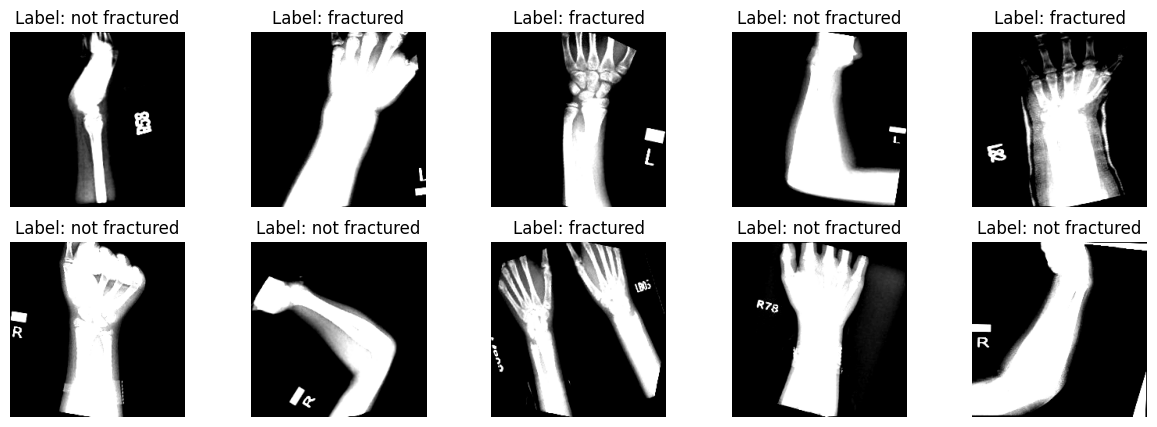

In [15]:
# Show a batch of images: This function will show a random batch of images from the training set norm.
show_batch(train_loader_norm)  

In [16]:
### Count each Class in Dataset
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = train_dataset_norm.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

train_class_distributions = class_counts(train_dataset_norm)
train_class_distributions

100%|██████████| 4097/4097 [00:10<00:00, 404.90it/s]


fractured        2078
not fractured    2019
dtype: int64

In [17]:
test_class_distributions = class_counts(test_dataset_norm)
test_class_distributions

100%|██████████| 399/399 [00:02<00:00, 195.81it/s]


fractured        199
not fractured    200
dtype: int64

In [18]:
val_class_distributions = class_counts(val_dataset_norm)
val_class_distributions

100%|██████████| 404/404 [00:01<00:00, 231.75it/s]


fractured        168
not fractured    236
dtype: int64

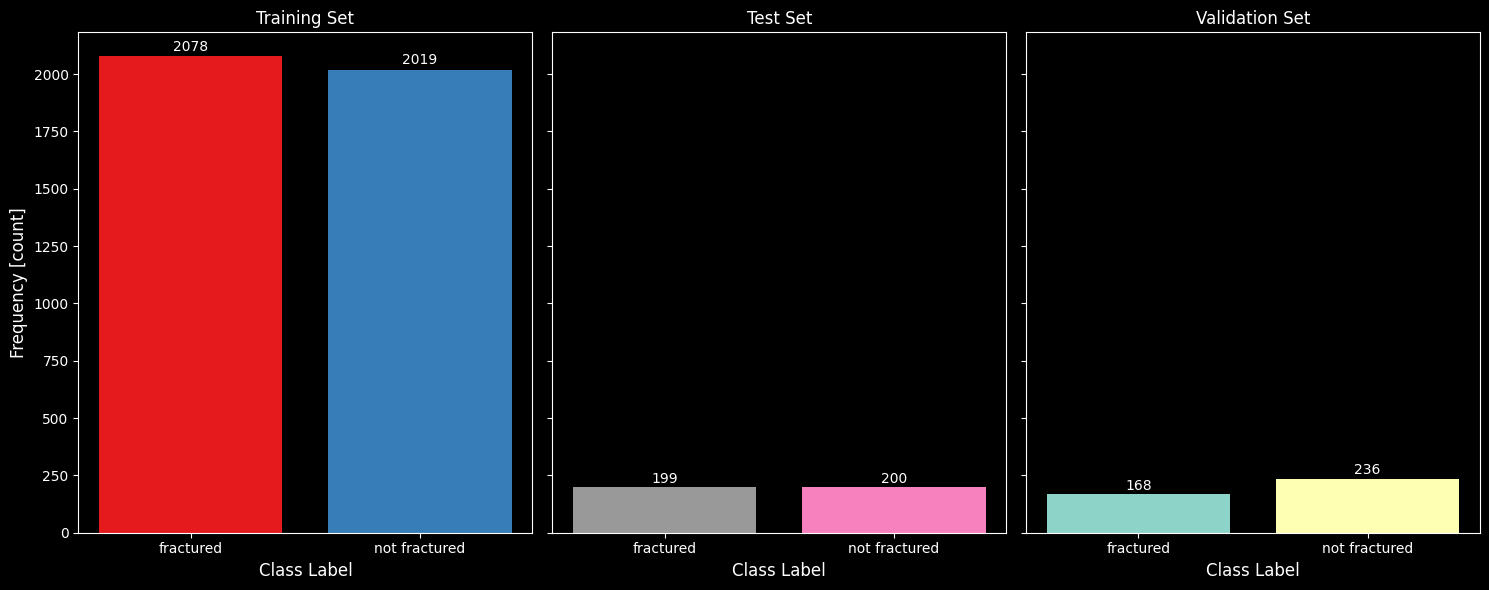

In [19]:
class_labels = train_dataset_norm.classes  # Class labels
plt.style.use('dark_background')
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Plot training set distribution
axes[0].bar(class_labels, train_class_distributions, color=[plt.cm.get_cmap("Set1", 10)(i) for i in range(9)])
axes[0].set_title("Training Set",fontsize=12)
axes[0].set_xlabel("Class Label",fontsize=12)
axes[0].set_ylabel("Frequency [count]",fontsize=12)

# Add counts above bars for the training set
for i, count in enumerate(train_class_distributions):
    axes[0].text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

# Plot test set distribution
axes[1].bar(class_labels, test_class_distributions, color=[plt.cm.get_cmap("Set1_r", 10)(i) for i in range(9)])
axes[1].set_title("Test Set",fontsize=12)
axes[1].set_xlabel("Class Label",fontsize=12)

# Add counts above bars for the test set
for i, count in enumerate(test_class_distributions):
    axes[1].text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Plot validation set distribution
axes[2].bar(class_labels, val_class_distributions, color=[plt.cm.get_cmap("Set3", 10)(i) for i in range(9)])
axes[2].set_title("Validation Set",fontsize=12)
axes[2].set_xlabel("Class Label",fontsize=12)

# Add counts above bars for the validation set
for i, count in enumerate(val_class_distributions):
    axes[2].text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [20]:
### Building a Shallow Neural Network
#We're now ready to create our first neural network model. The model will be a shallow fully connected network. 
#The input layer
#Two hidden layers
#The output layer
# Image size from our transformer
height = 224
width = 224
torch.manual_seed(42)
model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3*height * width, 512),
        nn.ReLU(),
        nn.Dropout(p=.3),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.Linear(128, 2) 
    )
print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=2, bias=True)
)


In [21]:
summary(model, input_size=(64,3,height,width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 2]                   --
├─Flatten: 1-1                           [64, 150528]              --
├─Linear: 1-2                            [64, 512]                 77,070,848
├─ReLU: 1-3                              [64, 512]                 --
├─Dropout: 1-4                           [64, 512]                 --
├─Linear: 1-5                            [64, 128]                 65,664
├─ReLU: 1-6                              [64, 128]                 --
├─Dropout: 1-7                           [64, 128]                 --
├─Linear: 1-8                            [64, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (G): 4.94
Input size (MB): 38.54
Forward/backward pass size (MB): 0.33
Params size (MB): 308.55
Estimated Total Size (MB): 347.41

In [22]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
def train_epoch(model, optimizer, loss_fn, data_loader, device):
    # Initialize variables for loss and accuracy
    training_loss = 0.0
    correct = 0
    total = 0
    # Set the model in training mode
    model.train()
    # Iterate over all batches in the training set
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Move inputs and targets to the specified device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients to prepare for the next backpropagation
        optimizer.zero_grad()
        # Perform the forward pass and obtain the output
        output = model(inputs)
        # Calculate the loss
        loss = loss_fn(output, targets)
        # Perform backpropagation
        loss.backward()
        # Update model weights using the optimizer
        optimizer.step()
        # Update the cumulative training loss
        training_loss += loss.data.item() * inputs.size(0)
        # Calculate the number of correct predictions
        _, predicted = torch.max(output, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    # Calculate the average training loss over the epoch
    avg_loss = training_loss / len(data_loader.dataset)
    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct / total
    return avg_loss, accuracy

In [24]:
def predict(model, data_loader, device):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)
    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()
    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            # Move inputs to the specified device
            inputs = inputs.to(device)
            output = model(inputs)
            # The model produces the logits. This softmax function turns the
            # logits into probabilities. These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

In [25]:
def score(model, data_loader, loss_fn, device):
    # Initialize the total loss (cross entropy) and the number of correct predictions.
    total_loss = 0
    total_correct = 0
    # Set the model to evaluation mode.
    model.eval()
    # Disable gradient calculations for evaluation.
    with torch.no_grad():
        # Iterate over the batches in the data loader.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            # Move inputs and targets to the specified device.
            inputs, targets = inputs.to(device), targets.to(device)
            # Perform the forward pass.
            output = model(inputs)
            # Calculate the loss function for this batch.
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)
            # Calculate the correct predictions for this batch.
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()
    # Calculate the average loss and accuracy.
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    return avg_loss, accuracy

In [26]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20,device = "cuda",Training_Accuracy = True):
    results = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Validation Loss', 'Validation Accuracy'])
    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss and accuracy.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader,device)
        if Training_Accuracy:
            training_loss, training_accuracy = score(model, train_loader, loss_fn,device)
        else:
            training_accuracy = 0
        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn,device)
        # Print out the results
        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.4f}, "
            f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}"
        )
        # Store the results in the dictionary
        results = pd.concat([results, pd.DataFrame({
            'Epoch': [epoch],
            'Training Loss': [training_loss],
            'Training Accuracy': [training_accuracy],
            'Validation Loss': [validation_loss],
            'Validation Accuracy': [validation_accuracy]
        })], ignore_index=True)
    return results  # Return the dictionary containing all results

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [28]:
results = train(model, optimizer, loss_fn, train_loader_norm, val_loader_norm, epochs=10,device=device)

Epoch: 1, Training Loss: 2.7167, Training Accuracy: 0.6214, Validation Loss: 0.4720, Validation Accuracy: 0.7550


Epoch: 2, Training Loss: 0.5452, Training Accuracy: 0.7252, Validation Loss: 0.3459, Validation Accuracy: 0.8243


Epoch: 3, Training Loss: 0.4781, Training Accuracy: 0.7725, Validation Loss: 0.2503, Validation Accuracy: 0.9109


Epoch: 4, Training Loss: 0.3352, Training Accuracy: 0.8379, Validation Loss: 0.1481, Validation Accuracy: 0.9257


Epoch: 5, Training Loss: 0.2901, Training Accuracy: 0.8765, Validation Loss: 0.1025, Validation Accuracy: 0.9604


Epoch: 6, Training Loss: 0.2131, Training Accuracy: 0.9092, Validation Loss: 0.0922, Validation Accuracy: 0.9653


Epoch: 7, Training Loss: 0.1650, Training Accuracy: 0.9361, Validation Loss: 0.0594, Validation Accuracy: 0.9752


Epoch: 8, Training Loss: 0.1404, Training Accuracy: 0.9436, Validation Loss: 0.0802, Validation Accuracy: 0.9653


Epoch: 9, Training Loss: 0.1432, Training Accuracy: 0.9436, Validation Loss: 0.1009, Validation Accuracy: 0.9653


Epoch: 10, Training Loss: 0.1071, Training Accuracy: 0.9595, Validation Loss: 0.0327, Validation Accuracy: 0.9851


In [29]:
# After the training loop, plot the results
def plot_results(results):
    # Set a dark background style
    plt.style.use('dark_background')
    # Create subplots for training and validation losses and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    # Plot training and validation losses
    ax[0].plot(results['Epoch'], results['Training Loss'], label='Training Loss')
    ax[0].plot(results['Epoch'], results['Validation Loss'], label='Validation Loss')
    ax[0].set_title('Losses Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    # Plot validation accuracy
    ax[1].plot(results['Epoch'], results['Training Accuracy'], label='Training Accuracy')
    ax[1].plot(results['Epoch'], results['Validation Accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    # Show the plots
    plt.tight_layout()
    plt.show()

In [30]:
results

,Epoch,Training Loss,Validation Loss,Validation Accuracy,Training Accuracy
0,1,2.716709,0.471987,0.754950,0.621430
1,2,0.545174,0.345865,0.824257,0.725165
2,3,0.478125,0.250348,0.910891,0.772516
3,4,0.335230,0.148137,0.925743,0.837930
4,5,0.290120,0.102543,0.960396,0.876495
5,6,0.213051,0.092174,0.965347,0.909202
6,7,0.165042,0.059404,0.975248,0.936051
7,8,0.140410,0.080192,0.965347,0.943617
8,9,0.143216,0.100939,0.965347,0.943617
9,10,0.107062,0.032654,0.985149,0.959483


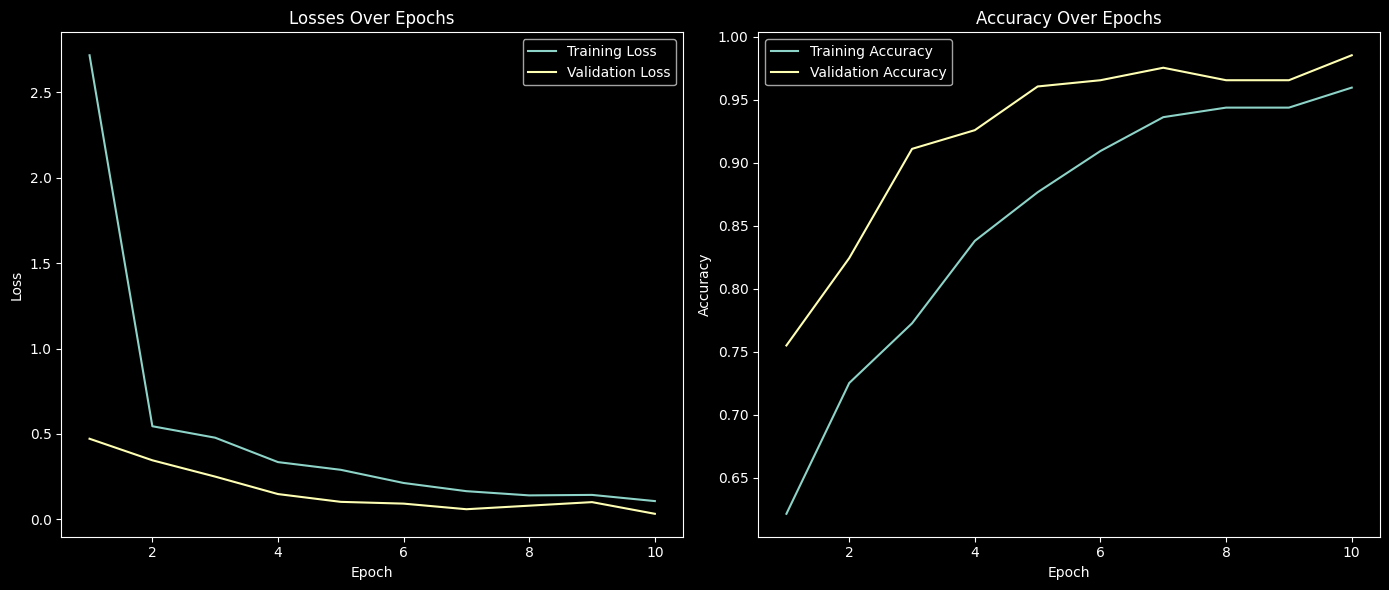

In [31]:
plot_results(results)

In [32]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0680, Testing Accuracy: 0.9699


In [33]:
### Make a prediction for each image in the validation set.
probabilities_test = predict(model, test_loader_norm,device)
predictions_test = torch.argmax(probabilities_test, dim=1)
print(predictions_test[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [34]:
true_labels = torch.cat([labels for _, labels in test_loader_norm], dim=0)
true_labels[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
show_batch(test_loader_norm,predict_labels=predictions_test[:64])

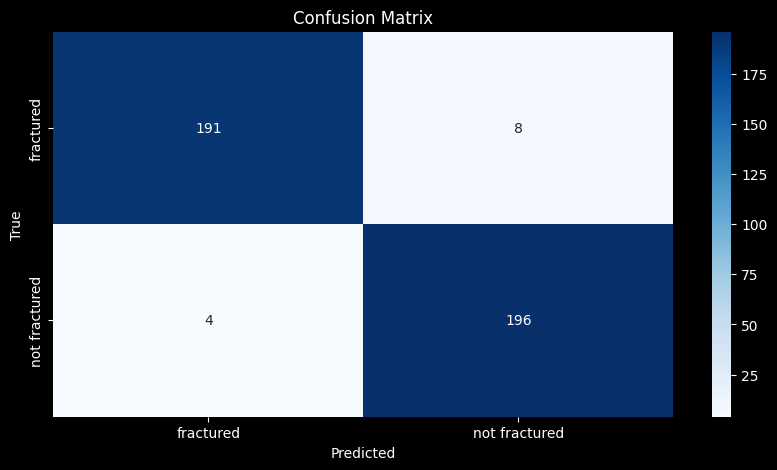

array([[191,   8],
       [  4, 196]])

In [35]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.numpy(), predictions_test.cpu().numpy())
# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset_norm.classes, yticklabels=train_dataset_norm.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
conf_matrix

In [36]:
# Generate the classification report
report = classification_report(true_labels.numpy(), predictions_test.cpu().numpy(), target_names=train_dataset_norm.classes)
# Print the classification report
print("Classification Report :\n",report)

Classification Report :
                precision    recall  f1-score   support

    fractured       0.98      0.96      0.97       199
not fractured       0.96      0.98      0.97       200

     accuracy                           0.97       399
    macro avg       0.97      0.97      0.97       399
 weighted avg       0.97      0.97      0.97       399



In [37]:
### save and load model 
torch.save(model,'mnist_model_nn.pth')
model = torch.load('mnist_model_nn.pth',weights_only=False)
model.to(device)

<All keys matched successfully>

In [38]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0680, Testing Accuracy: 0.9699


In [39]:
### CNN Model
cnn_model = nn.Sequential(
        # First convolutional layer, followed by ReLU and MaxPool2d
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Input channels = 3 (RGB), Output channels = 32
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # Pooling layer to reduce spatial dimensions
        # Second convolutional layer, followed by ReLU and MaxPool2d
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Input channels = 32, Output channels = 64
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # Pooling layer to further reduce spatial dimensions
        nn.Dropout(.3),
        # Flatten layer to convert 2D image data to 1D vector
        nn.Flatten(),
        # Fully connected layer (FC1) with 512 neurons
        nn.Linear(3136*64, 512),  # Input size depends on the output shape from the conv layers
        nn.ReLU(),
        nn.Dropout(.2),
        # Output layer with 10 neurons (for 10 classes)
        nn.Linear(512, 2)
    )
print("model type:", type(cnn_model))
print("model structure:")
print(cnn_model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.3, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=200704, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=512, out_features=2, bias=True)
)


In [40]:
summary(cnn_model, input_size=(64, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 2]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─ReLU: 1-2                              [64, 32, 224, 224]        --
├─MaxPool2d: 1-3                         [64, 32, 112, 112]        --
├─Conv2d: 1-4                            [64, 64, 112, 112]        18,496
├─ReLU: 1-5                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-6                         [64, 64, 56, 56]          --
├─Dropout: 1-7                           [64, 64, 56, 56]          --
├─Flatten: 1-8                           [64, 200704]              --
├─Linear: 1-9                            [64, 512]                 102,760,960
├─ReLU: 1-10                             [64, 512]                 --
├─Dropout: 1-11                          [64, 512]                 --
├─Linear: 1-12                           [64, 2]                   1,02

In [41]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # For classification tasks
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
cnn_model.to(device)

In [42]:
results = train(cnn_model, optimizer, loss_fn, train_loader_norm, val_loader_norm, epochs=10,device=device)

Epoch: 1, Training Loss: 1.3648, Training Accuracy: 0.6800, Validation Loss: 0.2792, Validation Accuracy: 0.9010


Epoch: 2, Training Loss: 0.2162, Training Accuracy: 0.9180, Validation Loss: 0.0808, Validation Accuracy: 0.9901


Epoch: 3, Training Loss: 0.0611, Training Accuracy: 0.9854, Validation Loss: 0.0165, Validation Accuracy: 0.9950


Epoch: 4, Training Loss: 0.0268, Training Accuracy: 0.9907, Validation Loss: 0.0131, Validation Accuracy: 0.9975


Epoch: 5, Training Loss: 0.0227, Training Accuracy: 0.9927, Validation Loss: 0.0022, Validation Accuracy: 1.0000


Epoch: 6, Training Loss: 0.0081, Training Accuracy: 0.9983, Validation Loss: 0.0010, Validation Accuracy: 1.0000


Epoch: 7, Training Loss: 0.0023, Training Accuracy: 0.9995, Validation Loss: 0.0017, Validation Accuracy: 1.0000


Epoch: 8, Training Loss: 0.0079, Training Accuracy: 0.9976, Validation Loss: 0.0023, Validation Accuracy: 1.0000


Epoch: 9, Training Loss: 0.0039, Training Accuracy: 0.9988, Validation Loss: 0.0002, Validation Accuracy: 1.0000


Epoch: 10, Training Loss: 0.0011, Training Accuracy: 0.9998, Validation Loss: 0.0001, Validation Accuracy: 1.0000


In [43]:
results

,Epoch,Training Loss,Validation Loss,Validation Accuracy,Training Accuracy
0,1,1.364752,0.279155,0.900990,0.680010
1,2,0.216150,0.080827,0.990099,0.917989
2,3,0.061059,0.016532,0.995050,0.985355
3,4,0.026834,0.013140,0.997525,0.990725
4,5,0.022718,0.002209,1.000000,0.992678
5,6,0.008096,0.000992,1.000000,0.998291
6,7,0.002316,0.001678,1.000000,0.999512
7,8,0.007879,0.002286,1.000000,0.997559
8,9,0.003864,0.000190,1.000000,0.998780
9,10,0.001091,0.000056,1.000000,0.999756


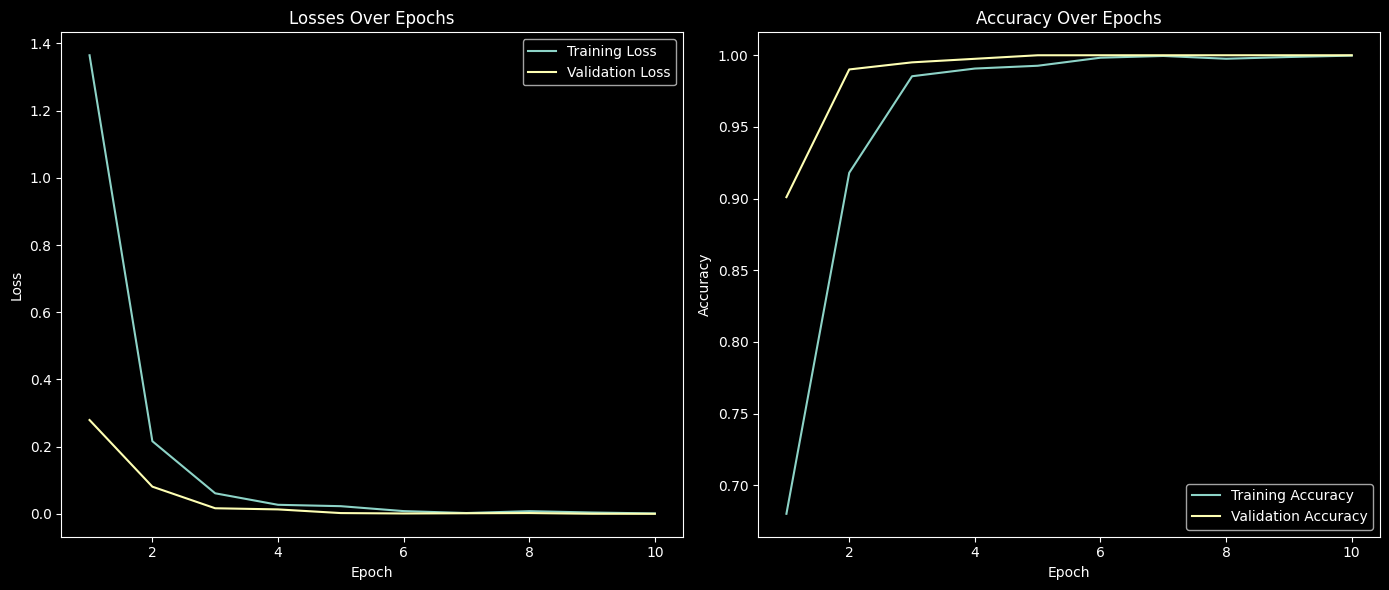

In [44]:
plot_results(results)

In [45]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(cnn_model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0115, Testing Accuracy: 0.9975


In [46]:
### Make a prediction for each image in the validation set.
probabilities_test = predict(cnn_model, test_loader_norm,device)
predictions_test = torch.argmax(probabilities_test, dim=1)
print(predictions_test[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [ ]:
show_batch(test_loader_norm,predict_labels=predictions_test[:64])

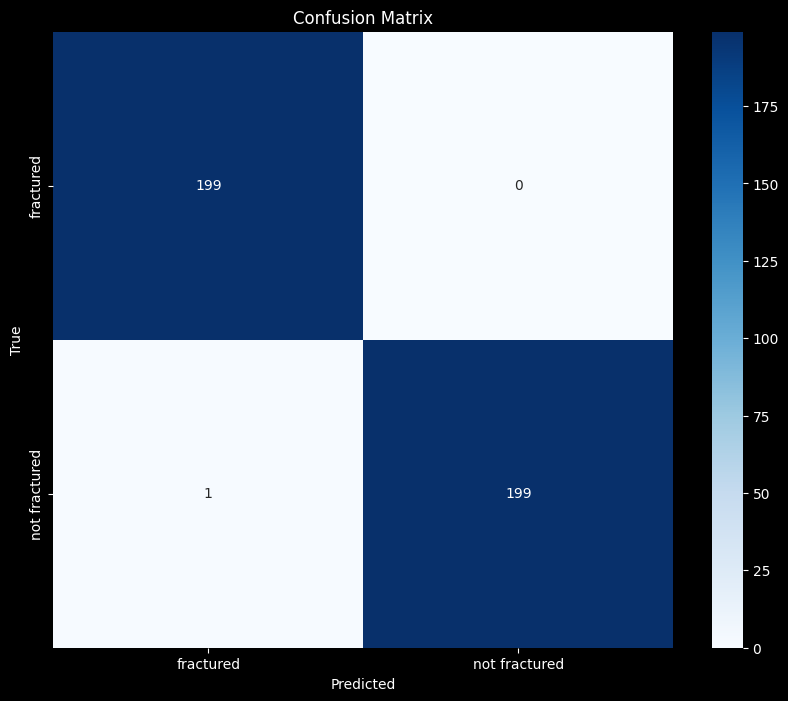

array([[199,   0],
       [  1, 199]])

In [47]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.numpy(), predictions_test.cpu().numpy())
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset_norm.classes, yticklabels=train_dataset_norm.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
conf_matrix

In [48]:
# Generate the classification report
report = classification_report(true_labels.numpy(), predictions_test.cpu().numpy(), target_names=train_dataset_norm.classes)
# Print the classification report
print("Classification Report :\n",report)

Classification Report :
                precision    recall  f1-score   support

    fractured       0.99      1.00      1.00       199
not fractured       1.00      0.99      1.00       200

     accuracy                           1.00       399
    macro avg       1.00      1.00      1.00       399
 weighted avg       1.00      1.00      1.00       399



In [49]:
### save and load model 
torch.save(cnn_model,'mnist_model_cnn.pth')
cnn_model = torch.load('mnist_model_cnn.pth',weights_only=False)
cnn_model.to(device)

<All keys matched successfully>

In [50]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(cnn_model, test_loader_norm, loss_fn,"cpu")
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0115, Testing Accuracy: 0.9975
